# Protein Alignment Pipeline using ESM-2 Embeddings

**Pipeline Overview:**
1. **Data Loading & Cleaning**: Load FASTA files, validate sequences, remove duplicates
2. **Chunking**: Split proteins into overlapping chunks for local alignment
3. **Embedding**: Generate ESM-2 embeddings for each chunk
4. **Similarity & Alignment**: Compute cosine similarity and find aligned regions using Smith-Waterman
5. **Descriptors**: Compute biochemical, structural, and functional descriptors
6. **Export**: Save results with rich metadata

---

## Organism Selection

In [ ]:
#Klebsiella_pneumoniae
#Homo_sapiens
#Escherichia_coli
#Enterococcus_faecalis
#Bifidobacterium_longum
#Bacteroides_fragilis

## 1. Data Loading & Cleaning

Load protein sequences from FASTA files and perform quality control.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 101.1 MB/s eta 0:00:00


In [3]:

from Bio import SeqIO
import pandas as pd
import glob
import os

fasta_path = "/content/drive/MyDrive/uniprotkb/*.fasta"

# Dictionary to store one DataFrame per organism
dfs = {}

for fasta_file in glob.glob(fasta_path):
    organism_name = os.path.basename(fasta_file).replace('.fasta', '')
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        data.append({
            "organism": organism_name,
            "protein_id": record.id,
            "sequence": str(record.seq)
        })

    # Create a DataFrame for this organism
    dfs[organism_name] = pd.DataFrame(data)

print(dfs['Homo_sapiens'].head())

       organism                    protein_id  \
0  Homo_sapiens  tr|A0A023HI15|A0A023HI15_HV1   
1  Homo_sapiens  tr|A0A023HI18|A0A023HI18_HV1   
2  Homo_sapiens  tr|A0A023HI37|A0A023HI37_HV1   
3  Homo_sapiens  tr|A0A023HIB6|A0A023HIB6_HV1   
4  Homo_sapiens  tr|A0A023HIP6|A0A023HIP6_HV1   

                                            sequence  
0  FFRENLAFQGKARKFSSEQTRANSPTSRKLGDGGGELTEAGTKRQG...  
1  MRVKGIRKNCPHLWRWGTMLLGMLMICSAAEQLWVTVYYGVPVWKE...  
2  FFRENLAFQGKARKFSSEQTRANSPTSRKLGDGGGELTEAGTERQX...  
3  MEPVDPNLEPWNHPGSKPTTACSKCYCKKCCWHCQLCFLKKGLGIS...  
4  MRVKGIRKNWTHLWRWGTMLLGMLMICSTAEQLWVTVYYGVPVWKE...  


In [4]:
import re
import pandas as pd
from collections import Counter

# Define valid amino acids
valid_aas = set("ACDEFGHIKLMNPQRSTVWY")

def invalid_stats(seq):
    seq = seq.upper()
    total = len(seq)
    invalids = [aa for aa in seq if aa not in valid_aas]
    invalid_count = len(invalids)
    invalid_pct = (invalid_count / total) * 100 if total > 0 else 0
    return invalid_pct, invalids

def clean_sequence(seq):
    seq = seq.upper()
    # replace ambiguous residues with X
    seq = re.sub(r"[BZUO\*]", "X", seq)
    # remove any other weird characters
    seq = re.sub(r"[^ACDEFGHIKLMNPQRSTVWYX]", "", seq)
    return seq

INVALID_THRESHOLD = 10.0  # percent per sequence
cleaned_dfs = {}

for organism, df in dfs.items():
    print(f"\nProcessing {organism} ...")

    total_sequences = len(df)
    invalid_pcts = []
    all_invalids = Counter()

    for seq in df["sequence"]:
        pct, invalid_list = invalid_stats(seq)
        invalid_pcts.append(pct)
        all_invalids.update(invalid_list)

    df["invalid_percentage"] = invalid_pcts

    # === Proteome-level stats ===
    # Average invalid % per proteome
    avg_invalid_pct = (sum(df["invalid_percentage"]) / len(df)) if len(df) > 0 else 0

    # Breakdown of invalid residues
    total_invalid_residues = sum(all_invalids.values())
    total_residues = sum(len(seq) for seq in df["sequence"])
    breakdown = {aa: f"{count} ({(count / total_residues) * 100:.3f}%)"
                 for aa, count in all_invalids.items()}

    # === Cleaning ===
    too_invalid = df[df["invalid_percentage"] > INVALID_THRESHOLD]
    df = df[df["invalid_percentage"] <= INVALID_THRESHOLD].copy()
    df["sequence"] = df["sequence"].apply(clean_sequence)

    short_seqs = df[df["sequence"].str.len() <= 50]
    df = df[df["sequence"].str.len() > 50]

    dup_count = df.duplicated(subset=["sequence"]).sum()
    df = df.drop_duplicates(subset=["sequence"])

    cleaned_dfs[organism] = df

    # === Reporting ===
    print(f"  → Sequences before cleaning: {total_sequences}")
    print(f"  → Average % invalid residues (per proteome): {avg_invalid_pct:.3f}%")
    print(f"  → Invalid residues found: {list(all_invalids.keys())}")
    print(f"  → Breakdown by character: {breakdown}")
    print(f"  → Sequences deleted (>10% invalid): {len(too_invalid)}")
    print(f"  → Sequences <50 aa removed: {len(short_seqs)}")
    print(f"  → Duplicate sequences removed: {dup_count}")
    print(f"  Kept {len(df)} clean sequences.\n")



Processing Enterococcus_faecalis ...
  → Sequences before cleaning: 40000
  → Average % invalid residues (per proteome): 0.001%
  → Invalid residues found: ['X']
  → Breakdown by character: {'X': '147 (0.001%)'}
  → Sequences deleted (>10% invalid): 0
  → Sequences <50 aa removed: 1153
  → Duplicate sequences removed: 8115
  Kept 30732 clean sequences.


Processing Bacteroides_fragilis ...
  → Sequences before cleaning: 40000
  → Average % invalid residues (per proteome): 0.000%
  → Invalid residues found: ['X']
  → Breakdown by character: {'X': '24 (0.000%)'}
  → Sequences deleted (>10% invalid): 0
  → Sequences <50 aa removed: 1903
  → Duplicate sequences removed: 11241
  Kept 26856 clean sequences.


Processing Bifidobacterium_longum ...
  → Sequences before cleaning: 40000
  → Average % invalid residues (per proteome): 0.000%
  → Invalid residues found: ['X']
  → Breakdown by character: {'X': '23 (0.000%)'}
  → Sequences deleted (>10% invalid): 0
  → Sequences <50 aa removed: 466


## 2. Chunking + Embedding + Similarity Matrix

Generate overlapping chunks, compute ESM-2 embeddings, and calculate cosine similarity between chunks.

In [5]:
# Install required packages
!pip install fair-esm
!pip install faiss-cpu
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # adjust CUDA version
!pip install tqdm pandas pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 109.4 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118


In [6]:
import os, sys, time, math
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# Paths (adjust if necessary)
DRIVE_BASE = "/content/drive/MyDrive/uniprotkb"
OUTPUT_BASE = "/content/drive/MyDrive/uniprotkb/pfam_output_esmpipeline"
os.makedirs(OUTPUT_BASE, exist_ok=True)

HUMAN = "Homo_sapiens"
BACT = "Klebsiella_pneumoniae"

# Chunking parameters (your choice)
CHUNK_LEN = 10
CHUNK_STRIDE = 5

# Smith-Waterman DP parameters
GAP_OPEN = -0.2
GAP_EXTEND = -0.1

# FAISS / search params
TOP_K_PER_CHUNK = 20        # k for chunk->chunk retrieval
QUICK_TOP_CANDIDATES = 200  # number of candidate bacterial proteins per human to run DP on
THRESHOLD_CHUNK_SCORE = 0.70  # threshold to count a good chunk hit

# Save/paths
CHUNKS_DIR = os.path.join(OUTPUT_BASE, "chunks")
EMB_DIR = os.path.join(OUTPUT_BASE, "embeddings")
INDEX_DIR = os.path.join(OUTPUT_BASE, "faiss")
os.makedirs(CHUNKS_DIR, exist_ok=True)
os.makedirs(EMB_DIR, exist_ok=True)
os.makedirs(INDEX_DIR, exist_ok=True)

print("HUMAN:", HUMAN, "BACT:", BACT)
print("Chunk len/stride:", CHUNK_LEN, CHUNK_STRIDE)
print("Output base:", OUTPUT_BASE)

HUMAN: Homo_sapiens BACT: Klebsiella_pneumoniae
Chunk len/stride: 10 5
Output base: /content/drive/MyDrive/uniprotkb/pfam_output_esmpipeline


In [7]:
#Load/validate cleaned_dfs from earlier code
try:
    cleaned_dfs  # if this exists, we use it
except NameError:
    raise RuntimeError("cleaned_dfs not found in current notebook. Run your cleaning cell first or load pickles.")

# Select the two proteomes
if HUMAN not in cleaned_dfs or BACT not in cleaned_dfs:
    raise RuntimeError(f"Organisms '{HUMAN}' or '{BACT}' not present in cleaned_dfs keys. Keys: {list(cleaned_dfs.keys())}")

df_human = cleaned_dfs[HUMAN].reset_index(drop=True).copy()
df_bact  = cleaned_dfs[BACT].reset_index(drop=True).copy()
print("Human proteins:", len(df_human), "Bacterial proteins:", len(df_bact))

Human proteins: 38818 Bacterial proteins: 32075


In [ ]:
#Chunking functions and run chunking (saves parquet files)
def generate_chunks_for_df(df, organism_name, chunk_len=10, stride=5, save_path=None):
    rows = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Chunking {organism_name}"):
        pid = row["protein_id"]
        seq = row["sequence"]
        L = len(seq)
        if L <= chunk_len:
            rows.append((organism_name, pid, 0, 1, L, seq))
            continue
        start = 0
        chunk_index = 0
        while start < L:
            end = min(start + chunk_len, L)
            subseq = seq[start:end]
            rows.append((organism_name, pid, chunk_index, start+1, end, subseq))
            chunk_index += 1
            start += stride
            if end == L:
                break
    df_chunks = pd.DataFrame(rows, columns=["organism", "protein_id", "chunk_index", "start", "end", "chunk_seq"])
    if save_path:
        df_chunks.to_parquet(save_path, index=False)
    return df_chunks

human_chunks_path = os.path.join(CHUNKS_DIR, f"{HUMAN}_chunks.parquet")
bact_chunks_path  = os.path.join(CHUNKS_DIR, f"{BACT}_chunks.parquet")

# generate if not exist
if not os.path.exists(human_chunks_path):
    human_chunks = generate_chunks_for_df(df_human, HUMAN, CHUNK_LEN, CHUNK_STRIDE, save_path=human_chunks_path)
else:
    human_chunks = pd.read_parquet(human_chunks_path)

if not os.path.exists(bact_chunks_path):
    bact_chunks = generate_chunks_for_df(df_bact, BACT, CHUNK_LEN, CHUNK_STRIDE, save_path=bact_chunks_path)
else:
    bact_chunks = pd.read_parquet(bact_chunks_path)

print("Human chunks:", len(human_chunks), "Bact chunks:", len(bact_chunks))
# Add index columns to refer later
human_chunks = human_chunks.reset_index().rename(columns={"index":"chunk_row"})
bact_chunks  = bact_chunks.reset_index().rename(columns={"index":"chunk_col"})
# Save updated tables
human_chunks.to_parquet(human_chunks_path, index=False)
bact_chunks.to_parquet(bact_chunks_path, index=False)

Chunking Klebsiella_pneumoniae: 100%|██████████| 32075/32075 [00:02<00:00, 13893.86it/s]


Human chunks: 6751564 Bact chunks: 2476291


In [8]:
# Select the two proteins to compare
HUMAN_PROT = "tr|A0A024RA31|A0A024RA31_HUMAN"
BACT_PROT  = "tr|A0A0C7KF14|A0A0C7KF14_KLEPN"

# Paths to chunk parquet files
human_chunks_path = "/content/drive/MyDrive/uniprotkb/pfam_output_esmpipeline/chunks/Homo_sapiens_chunks.parquet"
bact_chunks_path  = "/content/drive/MyDrive/uniprotkb/pfam_output_esmpipeline/chunks/Klebsiella_pneumoniae_chunks.parquet"

import os
import pandas as pd

# Helper function to chunk a single protein
def chunk_single_protein(protein_id, sequence, organism_name, chunk_len=10, stride=5):
    rows = []
    L = len(sequence)
    if L <= chunk_len:
        rows.append((organism_name, protein_id, 0, 1, L, sequence))
    else:
        start = 0
        chunk_index = 0
        while start < L:
            end = min(start + chunk_len, L)
            subseq = sequence[start:end]
            rows.append((organism_name, protein_id, chunk_index, start+1, end, subseq))
            chunk_index += 1
            start += stride
            if end == L:
                break
    df_chunks = pd.DataFrame(rows, columns=["organism", "protein_id", "chunk_index", "start", "end", "chunk_seq"])
    return df_chunks

# Check if the specific proteins exist in the parquet files and chunk them if missing
proteins_to_check = {
    'human': {'protein_id': HUMAN_PROT, 'chunks_path': human_chunks_path, 'organism': HUMAN},
    'bact': {'protein_id': BACT_PROT, 'chunks_path': bact_chunks_path, 'organism': BACT}
}

for prot_type, info in proteins_to_check.items():
    protein_id = info['protein_id']
    chunks_path = info['chunks_path']
    organism = info['organism']

    if os.path.exists(chunks_path):
        chunks_df = pd.read_parquet(chunks_path)

        if protein_id in chunks_df['protein_id'].values:
            print(f"[{prot_type.upper()}] Protein found in chunks")
        else:
            print(f"[{prot_type.upper()}] Protein not found - chunking separately...")

            try:
                df_source = cleaned_dfs[organism]
                protein_row = df_source[df_source['protein_id'] == protein_id]

                if not protein_row.empty:
                    sequence = protein_row.iloc[0]['sequence']
                    new_chunks = chunk_single_protein(protein_id, sequence, organism, CHUNK_LEN, CHUNK_STRIDE)
                    chunks_df = pd.concat([chunks_df, new_chunks], ignore_index=True)

                    if prot_type == 'human':
                        chunks_df = chunks_df.reset_index(drop=True).reset_index().rename(columns={"index":"chunk_row"})
                    else:
                        chunks_df = chunks_df.reset_index(drop=True).reset_index().rename(columns={"index":"chunk_col"})

                    chunks_df.to_parquet(chunks_path, index=False)
                    print(f"  Added {len(new_chunks)} chunks and saved")
                else:
                    print(f"  ERROR: Protein not found in cleaned_dfs['{organism}']")
            except Exception as e:
                print(f"  ERROR: Could not chunk protein: {e}")
    else:
        print(f"[{prot_type.upper()}] ERROR: Chunks file does not exist")

# Load the chunk parquet files
human_chunks = pd.read_parquet(human_chunks_path)
bact_chunks  = pd.read_parquet(bact_chunks_path)

print(f"\nLoaded {len(human_chunks)} human chunks, {len(bact_chunks)} bacterial chunks")

[HUMAN] Protein found in chunks
[BACT] Protein found in chunks

Loaded 6751564 human chunks, 2476291 bacterial chunks


In [9]:
# Extract chunks for the two proteins of interest
h_chunks = human_chunks[human_chunks["protein_id"] == HUMAN_PROT].sort_values("chunk_index").reset_index(drop=True)
b_chunks = bact_chunks[bact_chunks["protein_id"] == BACT_PROT].sort_values("chunk_index").reset_index(drop=True)

print(f"Human protein ({HUMAN_PROT}): {len(h_chunks)} chunks")
print(f"Bacterial protein ({BACT_PROT}): {len(b_chunks)} chunks")

if len(h_chunks) == 0 or len(b_chunks) == 0:
    raise RuntimeError("One of the proteins has no chunks. Check the protein IDs.")

Human protein (tr|A0A024RA31|A0A024RA31_HUMAN): 53 chunks
Bacterial protein (tr|A0A0C7KF14|A0A0C7KF14_KLEPN): 39 chunks


In [10]:
# Load ESM-2 model and define embedding function
import torch, numpy as np
from esm import pretrained
from torch.utils.data import DataLoader, Dataset

# Load ESM2-150M model
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Using device: {device}")

# Store ESM2 model globally for reuse in structural predictions
_global_esm2_model = model
_global_esm2_alphabet = alphabet
_global_esm2_device = device

# Dataset wrapper for batching sequences
class SeqDataset(Dataset):
    def __init__(self, ids, seqs):
        self.ids = ids
        self.seqs = seqs
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        return (self.ids[idx], self.seqs[idx])

def embed_list_of_seqs(seqs, ids=None, batch_size=6):
    """Generate ESM-2 embeddings for sequences with mean pooling."""
    if ids is None:
        ids = [str(i) for i in range(len(seqs))]
    ds = SeqDataset(ids, seqs)
    dl = DataLoader(ds, batch_size=batch_size, collate_fn=list)
    embs = []
    with torch.no_grad():
        for batch in dl:
            batch_list = [(b[0], b[1]) for b in batch]
            labels, strs, toks = batch_converter(batch_list)
            toks = toks.to(device)
            results = model(toks, repr_layers=[model.num_layers], return_contacts=False)
            rep = results["representations"][model.num_layers]
            for i, (_, seq) in enumerate(batch_list):
                L = len(seq)
                vec = rep[i, 1:L+1].mean(0).cpu().numpy().astype("float32")
                embs.append(vec)
    return np.vstack(embs)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt
Using device: cuda


In [11]:
# Generate embeddings for both protein chunks
h_seqs = h_chunks["chunk_seq"].astype(str).tolist()
b_seqs = b_chunks["chunk_seq"].astype(str).tolist()
h_ids  = h_chunks["protein_id"].astype(str) + "_c" + h_chunks["chunk_index"].astype(str)
b_ids  = b_chunks["protein_id"].astype(str) + "_c" + b_chunks["chunk_index"].astype(str)

print("Embedding human chunks...")
h_emb = embed_list_of_seqs(h_seqs, h_ids, batch_size=8)
print(f"Human: {h_emb.shape}")

print("Embedding bacterial chunks...")
b_emb = embed_list_of_seqs(b_seqs, b_ids, batch_size=8)
print(f"Bacterial: {b_emb.shape}")

Embedding human chunks...
Human: (53, 640)
Embedding bacterial chunks...
Bacterial: (39, 640)


In [12]:
# Compute cosine similarity matrix
import numpy as np
from sklearn.preprocessing import normalize

h_norm = normalize(h_emb, axis=1)
b_norm = normalize(b_emb, axis=1)

S = np.dot(h_norm, b_norm.T)
print(f"Similarity matrix: {S.shape} ({S.shape[0]} human × {S.shape[1]} bacterial chunks)")

# Summary statistics
print(f"Max: {S.max():.4f}, Mean: {S.mean():.4f}, Median: {np.median(S):.4f}")

top_k = min(100, S.size)
top_k_scores = np.partition(S.flatten(), -top_k)[-top_k:]
print(f"Mean of top {top_k} pairs: {top_k_scores.mean():.4f}")

Similarity matrix: (53, 39) (53 human × 39 bacterial chunks)
Max: 0.9846, Mean: 0.9391, Median: 0.9427
Mean of top 100 pairs: 0.9750


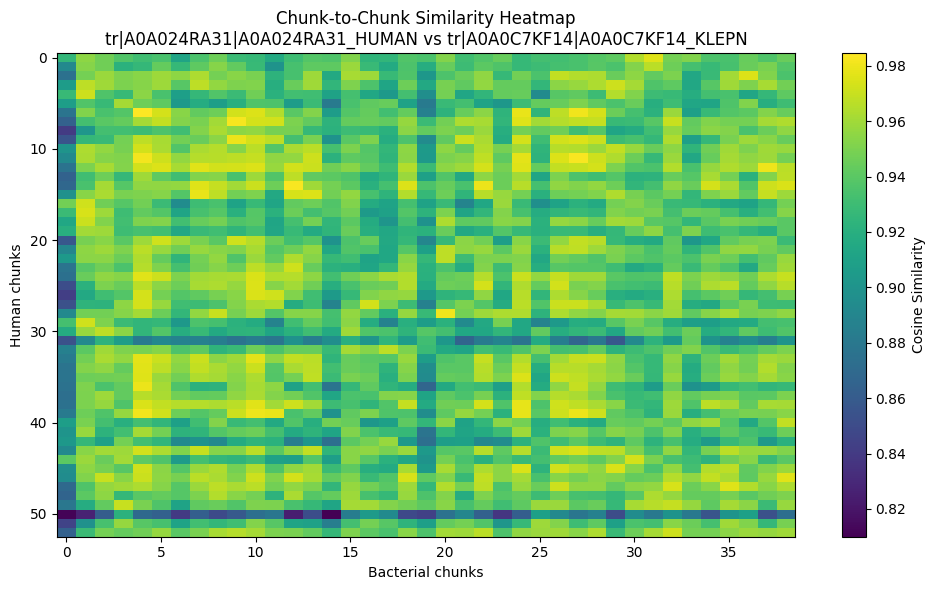

In [13]:
# Visualize the similarity matrix as a heatmap
# Bright regions indicate high similarity between chunk pairs
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.imshow(S, aspect='auto', cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title(f"Chunk-to-Chunk Similarity Heatmap\n{HUMAN_PROT} vs {BACT_PROT}")
plt.xlabel("Bacterial chunks")
plt.ylabel("Human chunks")
plt.tight_layout()
plt.show()

## 3. Chunk-Level Similarity & Alignment

Compute pairwise similarities and find aligned regions using Smith-Waterman algorithm.

In [14]:
# Display top chunk-pair matches (before alignment)
pairs = []
H, B = S.shape
for i in range(H):
    for j in range(B):
        pairs.append((i, j, float(S[i,j])))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

topN = 20
print(f"Top {topN} chunk-pair matches:\n")
print(f"{'H_idx':<8} {'B_idx':<8} {'Score':<10} {'Human Range':<15} {'Bact Range':<15}")
print("-" * 60)
for (i, j, score) in pairs_sorted[:topN]:
    h_row = h_chunks.iloc[i]
    b_row = b_chunks.iloc[j]
    print(f"{i:<8} {j:<8} {score:<10.4f} [{h_row.start}-{h_row.end}]"f"{'  ':<7} [{b_row.start}-{b_row.end}]")

Top 20 chunk-pair matches:

H_idx    B_idx    Score      Human Range     Bact Range     
------------------------------------------------------------
6        4        0.9846     [31-40]        [21-30]
14       12       0.9828     [71-80]        [61-70]
11       27       0.9826     [56-65]        [136-145]
7        9        0.9823     [36-45]        [46-55]
11       4        0.9812     [56-65]        [21-30]
39       4        0.9811     [196-205]        [21-30]
28       20       0.9810     [141-150]        [101-110]
6        27       0.9805     [31-40]        [136-145]
39       10       0.9802     [196-205]        [51-60]
12       37       0.9802     [61-70]        [186-195]
39       27       0.9798     [196-205]        [136-145]
36       4        0.9796     [181-190]        [21-30]
9        9        0.9795     [46-55]        [46-55]
14       22       0.9793     [71-80]        [111-120]
39       11       0.9791     [196-205]        [56-65]
6        24       0.9790     [31-40]        [1

# Smith-Waterman Multi-Alignment on Chunk Embeddings

This section performs AI-based local alignment using chunk embeddings instead of traditional sequence alignment.

**Key Features:**
- Finds ALL significant non-overlapping alignments (not just the best one)
- Uses Smith-Waterman algorithm on the cosine similarity matrix
- Applies adaptive quality filtering based on continuity and relative quality
- Masks found regions iteratively to discover multiple alignment regions

In [16]:
# Adaptive quality filtering
def filter_alignments_adaptive(alignments, S):
    """Filter alignments using data-driven thresholds."""
    if not alignments:
        return []

    best_aln = alignments[0]
    best_avg_sim = best_aln['avg_similarity']
    best_continuity = best_aln['continuity']
    best_score = best_aln['score']

    min_avg_sim = best_avg_sim * 0.90
    min_continuity = max(0.5, best_continuity * 0.6)
    min_relative_score = best_score * 0.20

    print(f"Adaptive thresholds:")
    print(f"  Best: score={best_score:.3f}, similarity={best_avg_sim:.3f}, continuity={best_continuity:.3f}")
    print(f"  Min similarity: {min_avg_sim:.3f}, continuity: {min_continuity:.3f}, score: {min_relative_score:.3f}\n")

    filtered = []
    for i, aln in enumerate(alignments):
        passes = True
        reasons = []

        if aln['avg_similarity'] < min_avg_sim:
            passes = False
            reasons.append(f"sim {aln['avg_similarity']:.3f}")
        if aln['continuity'] < min_continuity:
            passes = False
            reasons.append(f"cont {aln['continuity']:.3f}")
        if aln['score'] < min_relative_score:
            passes = False
            reasons.append(f"score {aln['score']:.3f}")

        if passes:
            filtered.append(aln)
        else:
            print(f"  Filtered out alignment #{i+1}: {', '.join(reasons)}")

    return filtered

In [17]:
# Find all non-overlapping alignments by masking
def find_all_alignments(S, gap_open=-0.2, gap_extend=-0.1, score_threshold=0.5,
                        min_score=0.5, min_chunks=3):
    """Find multiple non-overlapping local alignments iteratively."""
    S_work = S.copy()
    all_alignments = []

    while True:
        score, alignment, _ = smith_waterman_chunks(S_work, gap_open, gap_extend, score_threshold)

        if score < min_score or len(alignment) < min_chunks:
            break

        h_indices = [a[0] for a in alignment]
        b_indices = [a[1] for a in alignment]
        h_range = (min(h_indices), max(h_indices))
        b_range = (min(b_indices), max(b_indices))

        avg_sim = np.mean([S[h, b] for h, b in alignment])
        h_span = h_range[1] - h_range[0] + 1
        b_span = b_range[1] - b_range[0] + 1
        num_aligned = len(alignment)
        continuity = num_aligned / max(h_span, b_span)

        all_alignments.append({
            'score': score,
            'alignment': alignment,
            'h_range': h_range,
            'b_range': b_range,
            'num_chunks': num_aligned,
            'avg_similarity': avg_sim,
            'h_span': h_span,
            'b_span': b_span,
            'continuity': continuity
        })

        # Mask found region
        for h_idx in range(h_range[0], h_range[1] + 1):
            for b_idx in range(b_range[0], b_range[1] + 1):
                S_work[h_idx, b_idx] = 0

    return all_alignments

In [19]:
# Smith-Waterman alignment function
import numpy as np

def smith_waterman_chunks(S, gap_open=-0.2, gap_extend=-0.1, score_threshold=0.5):
    """Smith-Waterman local alignment on chunk similarity matrix."""
    n_human, n_bact = S.shape
    H_matrix = np.zeros((n_human + 1, n_bact + 1))
    traceback = np.zeros((n_human + 1, n_bact + 1), dtype=int)
    max_score = 0
    max_pos = (0, 0)

    for i in range(1, n_human + 1):
        for j in range(1, n_bact + 1):
            sim = S[i-1, j-1] - score_threshold
            match = H_matrix[i-1, j-1] + sim
            gap_h = H_matrix[i-1, j] + (gap_extend if traceback[i-1, j] == 2 else gap_open)
            gap_b = H_matrix[i, j-1] + (gap_extend if traceback[i, j-1] == 3 else gap_open)

            scores = [0, match, gap_h, gap_b]
            best = np.argmax(scores)
            H_matrix[i, j] = scores[best]
            traceback[i, j] = best

            if H_matrix[i, j] > max_score:
                max_score = H_matrix[i, j]
                max_pos = (i, j)

    # Traceback
    alignment = []
    i, j = max_pos
    while i > 0 and j > 0 and H_matrix[i, j] > 0:
        if traceback[i, j] == 1:
            alignment.append((i-1, j-1))
            i -= 1
            j -= 1
        elif traceback[i, j] == 2:
            i -= 1
        elif traceback[i, j] == 3:
            j -= 1
        else:
            break

    alignment.reverse()
    return max_score, alignment, H_matrix

In [20]:
# Run alignment finding and filtering
all_alignments_raw = find_all_alignments(S, gap_open=GAP_OPEN, gap_extend=GAP_EXTEND,
                                          score_threshold=0.5, min_score=0.3, min_chunks=2)

print(f"Found {len(all_alignments_raw)} raw alignments\n")

all_alignments = filter_alignments_adaptive(all_alignments_raw, S)

print(f"\nFinal result: {len(all_alignments)} high-quality alignments (from {len(all_alignments_raw)} raw)")
print("="*70)

for i, aln in enumerate(all_alignments):
    h_start = h_chunks.iloc[aln['h_range'][0]]['start']
    h_end = h_chunks.iloc[aln['h_range'][1]]['end']
    b_start = b_chunks.iloc[aln['b_range'][0]]['start']
    b_end = b_chunks.iloc[aln['b_range'][1]]['end']

    print(f"\nAlignment #{i+1}:")
    print(f"  Human:    {h_start}-{h_end} ({h_end-h_start+1} aa)")
    print(f"  Bacteria: {b_start}-{b_end} ({b_end-b_start+1} aa)")
    print(f"  Score: {aln['score']:.4f}, Chunks: {aln['num_chunks']}, Similarity: {aln['avg_similarity']:.4f}, Continuity: {aln['continuity']:.0%}")

Found 15 raw alignments

Adaptive thresholds:
  Best: score=17.417, similarity=0.947, continuity=1.000
  Min similarity: 0.852, continuity: 0.600, score: 3.483

  Filtered out alignment #4: score 2.265
  Filtered out alignment #5: score 2.173
  Filtered out alignment #6: score 1.683
  Filtered out alignment #7: score 1.382
  Filtered out alignment #8: score 1.368
  Filtered out alignment #9: score 1.334
  Filtered out alignment #10: score 1.324
  Filtered out alignment #11: score 1.295
  Filtered out alignment #12: score 1.292
  Filtered out alignment #13: score 1.265
  Filtered out alignment #14: score 1.263
  Filtered out alignment #15: score 0.893

Final result: 3 high-quality alignments (from 15 raw)

Alignment #1:
  Human:    1-200 (200 aa)
  Bacteria: 1-197 (197 aa)
  Score: 17.4167, Chunks: 39, Similarity: 0.9466, Continuity: 100%

Alignment #2:
  Human:    196-269 (74 aa)
  Bacteria: 111-185 (75 aa)
  Score: 6.2779, Chunks: 14, Similarity: 0.9484, Continuity: 100%

Alignment #3

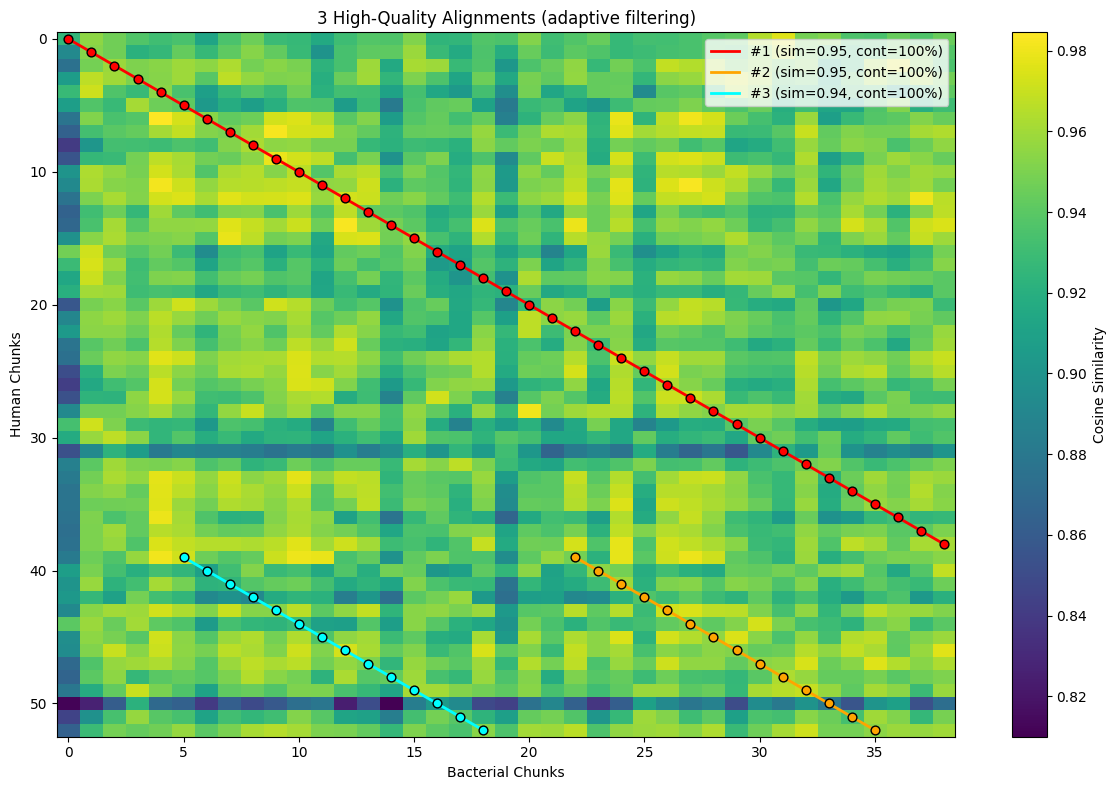


SUMMARY
Total human residues covered: 348 aa
Total bacterial residues covered: 347 aa
High-quality alignments: 3


In [21]:
# Visualize filtered aligned regions on the similarity matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(S, aspect='auto', cmap='viridis')
plt.colorbar(im, ax=ax, label='Cosine Similarity')

colors = ['red', 'orange', 'cyan', 'magenta', 'yellow', 'white']

for i, aln in enumerate(all_alignments):
    color = colors[i % len(colors)]
    path_h = [p[0] for p in aln['alignment']]
    path_b = [p[1] for p in aln['alignment']]

    ax.plot(path_b, path_h, '-', color=color, linewidth=2,
            label=f"#{i+1} (sim={aln['avg_similarity']:.2f}, cont={aln['continuity']:.0%})")
    ax.scatter(path_b, path_h, c=color, s=40, zorder=5, edgecolors='black')

ax.set_xlabel('Bacterial Chunks')
ax.set_ylabel('Human Chunks')
ax.set_title(f'{len(all_alignments)} High-Quality Alignments (adaptive filtering)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Summary
if all_alignments:
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    total_human_aa = sum(
        h_chunks.iloc[a['h_range'][1]]['end'] - h_chunks.iloc[a['h_range'][0]]['start'] + 1
        for a in all_alignments
    )
    total_bact_aa = sum(
        b_chunks.iloc[a['b_range'][1]]['end'] - b_chunks.iloc[a['b_range'][0]]['start'] + 1
        for a in all_alignments
    )
    print(f"Total human residues covered: {total_human_aa} aa")
    print(f"Total bacterial residues covered: {total_bact_aa} aa")
    print(f"High-quality alignments: {len(all_alignments)}")
else:
    print("\nNo alignments passed adaptive filtering.")

## 4. Biochemical, Structural & Functional Descriptors

Compute comprehensive descriptors for aligned regions to provide context for interpretation.

In [ ]:
# Biochemical + Structural Descriptors for Chunk Analysis
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import Counter
import math

def get_esm2_model():
    """Get the ESM2 model from global variables."""
    try:
        return _global_esm2_model, _global_esm2_alphabet, _global_esm2_device
    except NameError:
        return None, None, "cpu"

def compute_chunk_descriptors(sequence, include_structural=True):
    """
    Compute 16 descriptors for a protein chunk sequence.
    
    BIOCHEMICAL (12): length, aromaticity, aliphatic_fraction, GRAVY, 
    hydrophobic_fraction, polar_fraction, instability_index, charge_at_pH7,
    positive_fraction, negative_fraction, shannon_entropy
    
    STRUCTURAL (4): helix_fraction, sheet_fraction, disorder_fraction, 
    surface_exposed_fraction
    """
    clean_seq = ''.join([aa for aa in sequence.upper() if aa in 'ACDEFGHIKLMNPQRSTVWY'])

    if len(clean_seq) < 2:
        default = {
            "length": len(sequence), "aromaticity": 0.0, "aliphatic_fraction": 0.0,
            "GRAVY": 0.0, "hydrophobic_fraction": 0.0, "polar_fraction": 0.0,
            "instability_index": 0.0, "charge_at_pH7": 0.0, "positive_fraction": 0.0,
            "negative_fraction": 0.0, "shannon_entropy": 0.0
        }
        if include_structural:
            default.update({"helix_fraction": 0.0, "sheet_fraction": 0.0,
                          "disorder_fraction": 0.0, "surface_exposed_fraction": 0.5})
        return default

    try:
        analysis = ProteinAnalysis(clean_seq)
    except:
        fallback = {
            "length": len(sequence), "aromaticity": 0.0, "aliphatic_fraction": 0.0,
            "GRAVY": 0.0, "hydrophobic_fraction": 0.0, "polar_fraction": 0.0,
            "instability_index": 0.0, "charge_at_pH7": 0.0, "positive_fraction": 0.0,
            "negative_fraction": 0.0, "shannon_entropy": 0.0
        }
        if include_structural:
            fallback.update({"helix_fraction": 0.0, "sheet_fraction": 0.0,
                           "disorder_fraction": 0.0, "surface_exposed_fraction": 0.5})
        return fallback

    L = len(clean_seq)

    # Residue groups
    aliphatic = set('AVLIM')
    hydrophobic = set('AVLIMFWP')
    polar = set('STNQCY')
    positive = set('KRH')
    negative = set('DE')

    aa_counts = Counter(clean_seq)
    aliphatic_count = sum(aa_counts.get(aa, 0) for aa in aliphatic)
    hydrophobic_count = sum(aa_counts.get(aa, 0) for aa in hydrophobic)
    polar_count = sum(aa_counts.get(aa, 0) for aa in polar)
    positive_count = sum(aa_counts.get(aa, 0) for aa in positive)
    negative_count = sum(aa_counts.get(aa, 0) for aa in negative)

    # Shannon entropy
    def shannon_entropy(seq):
        counts = Counter(seq)
        total = len(seq)
        entropy = 0.0
        for count in counts.values():
            if count > 0:
                p = count / total
                entropy -= p * math.log2(p)
        return entropy

    # Build result with BioPython methods
    result = {
        "length": len(sequence),
        "aromaticity": round(analysis.aromaticity(), 4),
        "aliphatic_fraction": round(aliphatic_count / L, 4) if L > 0 else 0.0,
        "GRAVY": round(analysis.gravy(), 4),
        "hydrophobic_fraction": round(hydrophobic_count / L, 4) if L > 0 else 0.0,
        "polar_fraction": round(polar_count / L, 4) if L > 0 else 0.0,
        "instability_index": round(analysis.instability_index(), 4),
        "charge_at_pH7": round(analysis.charge_at_pH(7.0), 4),
        "positive_fraction": round(positive_count / L, 4) if L > 0 else 0.0,
        "negative_fraction": round(negative_count / L, 4) if L > 0 else 0.0,
        "shannon_entropy": round(shannon_entropy(clean_seq), 4)
    }

    # Add structural descriptors
    if include_structural:
        try:
            esm_model, esm_alphabet, esm_device = get_esm2_model()
            structural = compute_structural_descriptors(sequence, esm_model, esm_alphabet, esm_device)
            result.update(structural)
        except Exception as e:
            result.update({"helix_fraction": 0.0, "sheet_fraction": 0.0,
                          "disorder_fraction": 0.0, "surface_exposed_fraction": 0.5})

    return result


def compare_descriptors(desc_h, desc_b):
    """Compute differences between descriptors for comparison."""
    comparison = {}
    biochem_keys = ["aromaticity", "aliphatic_fraction", "GRAVY", "hydrophobic_fraction",
                    "polar_fraction", "instability_index", "charge_at_pH7",
                    "positive_fraction", "negative_fraction", "shannon_entropy"]
    structural_keys = ["helix_fraction", "sheet_fraction", "disorder_fraction",
                       "surface_exposed_fraction"]

    for key in biochem_keys + structural_keys:
        if key in desc_h and key in desc_b:
            diff = abs(desc_h[key] - desc_b[key])
            comparison[f"{key}_diff"] = round(diff, 4)
            threshold = 0.20 if key in structural_keys else 0.15
            comparison[f"{key}_similar"] = diff < threshold

    return comparison


# Test
test_desc = compute_chunk_descriptors("MEKTAYILGD", include_structural=False)
print("Test descriptors (biochemical):")
for k, v in list(test_desc.items())[:5]:
    print(f"  {k}: {v}")

print("\nDescriptor functions ready: 12 biochemical + 4 structural = 16 total")

esm_model, _, _ = get_esm2_model()
if esm_model is not None:
    print("ESM2 model detected - structural predictions enabled")
else:
    print("WARNING: ESM2 model not loaded - run ESM2 cell first")

In [ ]:
# Structural Descriptors - ESM2 + Propensity-based methods
import numpy as np

def predict_secondary_structure_esm2(sequence, model, alphabet, device="cuda"):
    """Predict secondary structure using ESM2 contact maps."""
    try:
        import torch
        batch_converter = alphabet.get_batch_converter()
        data = [("seq", sequence)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=True)

        contacts = results["contacts"][0].cpu().numpy()
        L = len(sequence)

        if L < 4:
            return 0.0, 0.0

        # Helix: i, i+3/i+4 contacts
        helix_score = sum(1 for i in range(L - 4) if contacts[i, i+3] > 0.3 or contacts[i, i+4] > 0.3)
        # Sheet: long-range contacts
        sheet_score = sum(1 for i in range(L) for j in range(i + 5, L) if contacts[i, j] > 0.3)

        helix_fraction = min(helix_score / max(L - 4, 1), 1.0)
        sheet_fraction = min(sheet_score / max((L * (L - 5)) / 2, 1) * 10, 1.0)

        return round(helix_fraction, 4), round(sheet_fraction, 4)
    except:
        return 0.0, 0.0


def predict_disorder_propensity(sequence):
    """Propensity-based disorder prediction."""
    disorder_prop = {
        'A': 0.06, 'R': 0.18, 'N': 0.13, 'D': 0.19, 'C': -0.20,
        'E': 0.24, 'Q': 0.18, 'G': 0.16, 'H': 0.05, 'I': -0.39,
        'L': -0.28, 'K': 0.21, 'M': -0.22, 'F': -0.35, 'P': 0.33,
        'S': 0.14, 'T': 0.05, 'W': -0.27, 'Y': -0.20, 'V': -0.32
    }

    clean_seq = ''.join([aa for aa in sequence.upper() if aa in 'ACDEFGHIKLMNPQRSTVWY'])
    if len(clean_seq) < 2:
        return 0.0

    scores = [disorder_prop.get(aa, 0.0) for aa in clean_seq]
    avg_score = sum(scores) / len(scores)
    disorder_fraction = max(0, min(1, (avg_score + 0.4) / 0.75))
    return round(disorder_fraction, 4)


def predict_surface_accessibility_propensity(sequence):
    """Propensity-based surface accessibility prediction."""
    rsa_prop = {
        'A': 0.48, 'R': 0.84, 'N': 0.76, 'D': 0.78, 'C': 0.32,
        'E': 0.82, 'Q': 0.78, 'G': 0.51, 'H': 0.66, 'I': 0.34,
        'L': 0.40, 'K': 0.85, 'M': 0.44, 'F': 0.35, 'P': 0.62,
        'S': 0.66, 'T': 0.60, 'W': 0.38, 'Y': 0.48, 'V': 0.36
    }

    clean_seq = ''.join([aa for aa in sequence.upper() if aa in 'ACDEFGHIKLMNPQRSTVWY'])
    if len(clean_seq) < 2:
        return 0.5

    scores = [rsa_prop.get(aa, 0.5) for aa in clean_seq]
    return round(sum(scores) / len(scores), 4)


def compute_structural_descriptors(sequence, model=None, alphabet=None, device="cuda"):
    """Compute all 4 structural descriptors."""
    # Secondary structure via ESM2
    if model is not None and alphabet is not None:
        helix_frac, sheet_frac = predict_secondary_structure_esm2(sequence, model, alphabet, device)
    else:
        helix_frac, sheet_frac = 0.0, 0.0

    # Disorder and surface - propensity based (fast and reliable)
    disorder_frac = predict_disorder_propensity(sequence)
    surface_frac = predict_surface_accessibility_propensity(sequence)

    return {
        "helix_fraction": helix_frac,
        "sheet_fraction": sheet_frac,
        "disorder_fraction": disorder_frac,
        "surface_exposed_fraction": surface_frac
    }


print("Structural descriptor functions loaded")
print("  - Secondary structure: ESM2-based")
print("  - Disorder: propensity-based")
print("  - Surface accessibility: propensity-based")

# Test
test_structural = compute_structural_descriptors("MEKTAYILGD")
print(f"\nTest: {test_structural}")


In [ ]:
# =============================================================================
# FUNCTIONAL DESCRIPTORS - Part 1: Setup and Pfam Domains
# =============================================================================

import requests
import time
import json
import re
import os

# Global cache for functional annotations
_functional_cache = {}

# =========================================================================
# PFAM SETUP - Install required dependencies (run once per Colab session)
# =========================================================================
print("Setting up PfamScan dependencies...")

# Install HMMER (required for PfamScan)
os.system("apt-get -qq update")
os.system("apt-get -qq install -y hmmer")

# Install required Perl modules
os.system("apt-get -qq install -y cpanminus")
os.system("cpanm -q Moose JSON List::MoreUtils 2>/dev/null")

print("PfamScan dependencies installed!")

# =========================================================================
# PFAM PATHS (your existing setup on Google Drive)
# =========================================================================
PFAM_DIR = "/content/drive/MyDrive/uniprotkb/pfam"
PFAM_SCAN_PATH = f"{PFAM_DIR}/PfamScan/pfam_scan.pl"
PFAM_TEMP_DIR = "/content/pfam_temp"

# Create temp directory
os.makedirs(PFAM_TEMP_DIR, exist_ok=True)


# =========================================================================
# 1. PFAM DOMAINS - LOCAL PfamScan (your Google Drive setup)
# =========================================================================

def parse_pfam_output(output_file):
    """
    Parse PfamScan output file and extract domain accessions.
    Returns list of Pfam domain accessions (e.g., ['PF00001', 'PF00002']).
    """
    domains = []
    try:
        with open(output_file, 'r') as f:
            for line in f:
                if line.startswith('#') or not line.strip():
                    continue

                parts = line.strip().split()
                if len(parts) >= 6:
                    # Column 6 contains Pfam accession (PF#####)
                    pfam_acc = parts[5]
                    if pfam_acc.startswith('PF') and pfam_acc not in domains:
                        domains.append(pfam_acc)
    except Exception as e:
        print(f"    Error parsing Pfam output: {e}")

    return domains


def search_pfam_domains(sequence, protein_id="unknown"):
    """
    Search Pfam domains using LOCAL PfamScan on Google Drive.
    Returns list of Pfam domain accessions.
    ~2-5 seconds per sequence
    """
    clean_id = protein_id.replace('|', '_').replace('/', '_')
    fasta_file = f"{PFAM_TEMP_DIR}/{clean_id}.fasta"
    output_file = f"{PFAM_TEMP_DIR}/{clean_id}_pfam.out"

    try:
        # Write sequence to temp FASTA
        with open(fasta_file, "w") as f:
            f.write(f">{clean_id}\n{sequence}\n")

        # Run PfamScan using os.system (works better in Colab)
        cmd = f"perl -I {PFAM_DIR}/PfamScan -I {PFAM_DIR}/PfamScan/Bio {PFAM_SCAN_PATH} -fasta {fasta_file} -dir {PFAM_DIR} -outfile {output_file} -cpu 2 2>/dev/null"

        exit_code = os.system(cmd)

        if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
            domains = parse_pfam_output(output_file)
            return domains
        else:
            # Check if PfamScan is accessible
            if not os.path.exists(PFAM_SCAN_PATH):
                print(f"    PfamScan not found at: {PFAM_SCAN_PATH}")
            elif not os.path.exists(f"{PFAM_DIR}/Pfam-A.hmm"):
                print(f"    Pfam-A.hmm not found in: {PFAM_DIR}")
            else:
                print(f"    PfamScan produced no output (exit code: {exit_code})")
            return []

    except Exception as e:
        print(f"    PfamScan error: {e}")
        return []
    finally:
        # Cleanup temp files
        try:
            if os.path.exists(fasta_file):
                os.remove(fasta_file)
            if os.path.exists(output_file):
                os.remove(output_file)
        except:
            pass

print("Pfam domain search functions loaded!")


In [ ]:
# =============================================================================
# FUNCTIONAL DESCRIPTORS - Part 2: Motifs, Signal Peptide, TM Helices
# =============================================================================

# =========================================================================
# 2. PROSITE MOTIFS - ScanProsite API
# =========================================================================

def search_prosite_motifs(sequence):
    """
    Search Prosite motifs using ScanProsite API.
    Returns list of Prosite pattern accessions.
    ~0.05 seconds per sequence
    """
    url = "https://prosite.expasy.org/cgi-bin/prosite/PSScan.cgi"

    params = {
        'seq': sequence,
        'output': 'json',
        'skip': 'false'
    }

    try:
        response = requests.post(url, data=params, timeout=30)

        if response.status_code == 200:
            # Try to parse JSON response
            try:
                results = response.json()
                motifs = []

                if 'matchset' in results:
                    for match in results['matchset']:
                        acc = match.get('signature_ac', '')
                        if acc and acc not in motifs:
                            motifs.append(acc)

                return motifs
            except:
                # Fallback: parse text response
                motifs = []
                text = response.text
                # Look for PS##### patterns
                pattern = re.findall(r'PS\d{5}', text)
                for p in pattern:
                    if p not in motifs:
                        motifs.append(p)
                return motifs
        else:
            print(f"    Prosite failed: HTTP {response.status_code}")
            return []

    except Exception as e:
        print(f"    Prosite error: {e}")
        return []


# =========================================================================
# 3. SIGNAL PEPTIDE - Heuristic (SignalP-like rules)
# =========================================================================

def predict_signal_peptide(sequence):
    """
    Predict signal peptide using heuristic rules based on SignalP characteristics:
    - Positive N-region (first 1-5 aa with K, R)
    - Hydrophobic H-region (aa 5-20 with high hydrophobic content)
    - Polar C-region with cleavage site

    Returns True if signal peptide detected, False otherwise.
    ~0.001 seconds per sequence
    """
    if len(sequence) < 20:
        return False

    n_term = sequence[:30].upper()

    # N-region: first 5 aa should have positive charge (K, R)
    n_region = n_term[:5]
    positive = sum(1 for aa in n_region if aa in 'KR')

    # H-region: aa 5-20 should be hydrophobic
    h_region = n_term[5:20]
    hydrophobic = set('AVILMFWP')
    hydro_count = sum(1 for aa in h_region if aa in hydrophobic)
    hydro_frac = hydro_count / len(h_region) if h_region else 0

    # Signal peptide if: some positive charges AND high hydrophobicity
    return positive >= 1 and hydro_frac >= 0.5


# =========================================================================
# 4. TRANSMEMBRANE HELICES - Heuristic (TMHMM-like prediction)
# =========================================================================

def predict_tm_helices(sequence):
    """
    Predict transmembrane helices using hydrophobicity-based heuristic.
    TM helices are typically 18-25 hydrophobic residues.

    Returns number of TM helices.
    ~0.001 seconds per sequence
    """
    hydrophobic = set('AVILMFWP')
    window_size = 20
    threshold = 0.65  # 65% hydrophobic

    tm_count = 0
    i = 0

    while i < len(sequence) - window_size:
        window = sequence[i:i+window_size].upper()
        hydro_frac = sum(1 for aa in window if aa in hydrophobic) / window_size

        if hydro_frac >= threshold:
            tm_count += 1
            i += window_size + 5  # Skip past this TM + short loop
        else:
            i += 1

    return tm_count


# =========================================================================
# MAIN FUNCTION - Combines all tools
# =========================================================================

def compute_functional_annotations(sequence, protein_id="unknown", use_cache=True):
    """
    Compute functional annotations using dedicated tools:
    - Pfam domains: LOCAL PfamScan (Google Drive)
    - Prosite motifs: ScanProsite API
    - Signal peptide: SignalP heuristic
    - TM helices: TMHMM heuristic

    Returns dict with all annotations.
    """
    global _functional_cache

    # Check cache
    if use_cache and protein_id in _functional_cache:
        print(f"  Using cached annotations for {protein_id}")
        return _functional_cache[protein_id]

    print(f"  Computing functional annotations for {protein_id} ({len(sequence)} aa)")

    annotations = {
        "predicted_domains": [],
        "predicted_motifs": [],
        "is_signal_peptide": False,
        "num_transmembrane_helices": 0
    }

    # 1. Pfam domains (LOCAL PfamScan)
    print(f"    Searching Pfam domains (local PfamScan)...")
    annotations["predicted_domains"] = search_pfam_domains(sequence, protein_id)
    print(f"       Found {len(annotations['predicted_domains'])} domains")

    # 2. Prosite motifs
    print(f"    Searching Prosite motifs...")
    annotations["predicted_motifs"] = search_prosite_motifs(sequence)
    print(f"       Found {len(annotations['predicted_motifs'])} motifs")

    # 3. Signal peptide (SignalP heuristic)
    print(f"    Predicting signal peptide...")
    annotations["is_signal_peptide"] = predict_signal_peptide(sequence)
    print(f"       Signal peptide: {annotations['is_signal_peptide']}")

    # 4. TM helices (TMHMM heuristic)
    print(f"    Predicting TM helices...")
    annotations["num_transmembrane_helices"] = predict_tm_helices(sequence)
    print(f"       TM helices: {annotations['num_transmembrane_helices']}")

    # Cache and return
    _functional_cache[protein_id] = annotations
    print(f"  Annotations complete for {protein_id}")

    return annotations


print("Functional annotation functions loaded!")
print("   Tool configuration:")
print(f"   |- Domains: LOCAL PfamScan ({PFAM_DIR})")
print("   |- Motifs: ScanProsite API")
print("   |- Signal peptide: Heuristic (SignalP-like)")
print("   |- TM helices: Heuristic (TMHMM-like)")


In [ ]:
# Helper functions for saving alignment results
import json
import os
from datetime import datetime

def get_full_seq(df, prot_id):
    """Fetch full sequence from dataframe by protein ID."""
    match = df[df["protein_id"] == prot_id]
    if not match.empty:
        return str(match.iloc[0]["sequence"])
    return None


def build_alignment_details(all_alignments, h_chunks, b_chunks, S, human_full_seq, bact_full_seq):
    """
    Build detailed alignment info with biochemical descriptors for each alignment.
    Returns list of alignment detail dicts.
    """
    alignment_details = []
    
    for i, aln in enumerate(all_alignments):
        h_start = int(h_chunks.iloc[aln['h_range'][0]]['start'])
        h_end = int(h_chunks.iloc[aln['h_range'][1]]['end'])
        b_start = int(b_chunks.iloc[aln['b_range'][0]]['start'])
        b_end = int(b_chunks.iloc[aln['b_range'][1]]['end'])

        # Extract aligned chunk pairs WITH biochemical descriptors
        aligned_pairs = []
        for h_idx, b_idx in aln['alignment']:
            h_seq = str(h_chunks.iloc[h_idx]['chunk_seq'])
            b_seq = str(b_chunks.iloc[b_idx]['chunk_seq'])

            # Compute biochemical descriptors for each chunk
            h_descriptors = compute_chunk_descriptors(h_seq)
            b_descriptors = compute_chunk_descriptors(b_seq)
            descriptor_comparison = compare_descriptors(h_descriptors, b_descriptors)

            aligned_pairs.append({
                "human_chunk_idx": int(h_idx),
                "bact_chunk_idx": int(b_idx),
                "cosine_similarity": float(S[h_idx, b_idx]),
                "human_chunk": {
                    "sequence": h_seq,
                    "range": [int(h_chunks.iloc[h_idx]['start']), int(h_chunks.iloc[h_idx]['end'])],
                    "descriptors": h_descriptors
                },
                "bacteria_chunk": {
                    "sequence": b_seq,
                    "range": [int(b_chunks.iloc[b_idx]['start']), int(b_chunks.iloc[b_idx]['end'])],
                    "descriptors": b_descriptors
                },
                "descriptor_comparison": descriptor_comparison
            })

        # Extract the full aligned region sequences
        human_aligned_region = human_full_seq[h_start-1:h_end] if human_full_seq else None
        bact_aligned_region = bact_full_seq[b_start-1:b_end] if bact_full_seq else None

        # Aggregate biochemical stats for the whole alignment
        avg_descriptors_h = {}
        avg_descriptors_b = {}
        if aligned_pairs:
            desc_keys = [k for k in aligned_pairs[0]['human_chunk']['descriptors'].keys()
                        if k not in ['length', 'aromatic_count']]
            for key in desc_keys:
                avg_descriptors_h[key] = round(np.mean([p['human_chunk']['descriptors'][key] for p in aligned_pairs]), 4)
                avg_descriptors_b[key] = round(np.mean([p['bacteria_chunk']['descriptors'][key] for p in aligned_pairs]), 4)

        alignment_details.append({
            "alignment_rank": i + 1,
            "smith_waterman_score": float(aln['score']),
            "num_chunks_aligned": int(aln['num_chunks']),
            "avg_cosine_similarity": float(aln['avg_similarity']),
            "continuity": float(aln['continuity']),
            "human_region": {
                "start": h_start,
                "end": h_end,
                "length_aa": h_end - h_start + 1,
                "sequence": human_aligned_region,
                "avg_descriptors": avg_descriptors_h
            },
            "bacteria_region": {
                "start": b_start,
                "end": b_end,
                "length_aa": b_end - b_start + 1,
                "sequence": bact_aligned_region,
                "avg_descriptors": avg_descriptors_b
            },
            "chunk_span": {
                "human_chunks": [int(aln['h_range'][0]), int(aln['h_range'][1])],
                "bact_chunks": [int(aln['b_range'][0]), int(aln['b_range'][1])],
                "human_span": int(aln['h_span']),
                "bact_span": int(aln['b_span'])
            },
            "chunk_pairs": aligned_pairs
        })
    
    return alignment_details

print("Save helper functions loaded!")


In [ ]:
# Main save function - Smith-Waterman results to JSON
def save_alignment_results(
    all_alignments,
    all_alignments_raw,
    h_chunks,
    b_chunks,
    S,
    human_prot_id,
    bact_prot_id,
    df_human,
    df_bact,
    save_dir="/content/drive/MyDrive/uniprotkb/pfam_output_esmpipeline/results",
    compute_functional=True
):
    """
    Save complete Smith-Waterman alignment results including:
    1. Global metadata (protein info, sequences, chunk stats)
    2. Smith-Waterman results (raw and filtered alignments)
    3. Biochemical descriptors (12 descriptors per chunk pair)
    4. Structural descriptors (4 descriptors per chunk pair)
    5. Functional annotations (4 annotations per protein) - via InterProScan API

    Args:
        compute_functional: whether to compute functional annotations (requires API, may take 1-5 min)
    """
    os.makedirs(save_dir, exist_ok=True)

    # Fetch full sequences
    human_full_seq = get_full_seq(df_human, human_prot_id)
    bact_full_seq = get_full_seq(df_bact, bact_prot_id)

    # =====================================================================
    # FUNCTIONAL ANNOTATIONS (Full Protein Level)
    # =====================================================================
    human_functional = None
    bact_functional = None

    if compute_functional:
        print("Computing functional annotations (this may take a few minutes)...")
        if human_full_seq:
            human_functional = compute_functional_annotations(
                human_full_seq,
                protein_id=human_prot_id
            )
            if human_functional is None:
                print("  Human protein functional annotations unavailable (API failed)")
        if bact_full_seq:
            bact_functional = compute_functional_annotations(
                bact_full_seq,
                protein_id=bact_prot_id
            )
            if bact_functional is None:
                print("  Bacteria protein functional annotations unavailable (API failed)")

    # =====================================================================
    # SIMILARITY MATRIX STATISTICS
    # =====================================================================
    top_k = min(20, S.size)
    topk_vals = np.sort(S.flatten())[-top_k:]

    sim_stats = {
        "matrix_shape": list(S.shape),
        "min_similarity": float(S.min()),
        "max_similarity": float(S.max()),
        "mean_similarity": float(S.mean()),
        "std_similarity": float(S.std()),
        "median_similarity": float(np.median(S)),
        f"mean_top_{top_k}": float(topk_vals.mean()),
        "percentile_90": float(np.percentile(S, 90)),
        "percentile_95": float(np.percentile(S, 95)),
        "percentile_99": float(np.percentile(S, 99))
    }

    # =====================================================================
    # BUILD ALIGNMENT DETAILS
    # =====================================================================
    alignment_details = build_alignment_details(
        all_alignments, h_chunks, b_chunks, S, human_full_seq, bact_full_seq
    )

    # =====================================================================
    # COMPLETE RESULTS STRUCTURE
    # =====================================================================
    results = {
        # --- METADATA ---
        "metadata": {
            "created_at": datetime.now().isoformat(),
            "pipeline_version": "ESM2-ChunkSW-v3.0",
            "description": "Smith-Waterman alignment on ESM2 chunk embeddings with biochemical, structural, and functional descriptors"
        },

        # --- INPUT SEQUENCES WITH FUNCTIONAL ANNOTATIONS ---
        "input_sequences": {
            "human": {
                "protein_id": human_prot_id,
                "full_sequence": human_full_seq,
                "length_aa": len(human_full_seq) if human_full_seq else 0,
                "num_chunks": int(len(h_chunks)),
                "functional_annotations": human_functional
            },
            "bacteria": {
                "protein_id": bact_prot_id,
                "full_sequence": bact_full_seq,
                "length_aa": len(bact_full_seq) if bact_full_seq else 0,
                "num_chunks": int(len(b_chunks)),
                "functional_annotations": bact_functional
            }
        },

        # --- CHUNKING & ALIGNMENT PARAMETERS ---
        "parameters": {
            "chunk_length": int(CHUNK_LEN),
            "chunk_stride": int(CHUNK_STRIDE),
            "overlap_percentage": round((CHUNK_LEN - CHUNK_STRIDE) / CHUNK_LEN * 100, 1),
            "smith_waterman": {
                "gap_open": float(GAP_OPEN),
                "gap_extend": float(GAP_EXTEND),
                "score_threshold": 0.5
            },
            "filtering": {
                "min_score": 0.3,
                "min_chunks": 2,
                "adaptive_thresholds": True,
                "note": "Thresholds computed relative to best alignment (90% sim, 60% continuity, 20% score)"
            }
        },

        # --- SIMILARITY MATRIX STATISTICS ---
        "similarity_matrix_stats": sim_stats,

        # --- ALIGNMENT SUMMARY ---
        "alignment_summary": {
            "raw_alignments_found": len(all_alignments_raw),
            "filtered_alignments": len(all_alignments),
            "total_human_aa_aligned": sum(a['human_region']['length_aa'] for a in alignment_details) if alignment_details else 0,
            "total_bact_aa_aligned": sum(a['bacteria_region']['length_aa'] for a in alignment_details) if alignment_details else 0,
            "best_score": alignment_details[0]['smith_waterman_score'] if alignment_details else None,
            "best_avg_similarity": alignment_details[0]['avg_cosine_similarity'] if alignment_details else None,
            "best_continuity": alignment_details[0]['continuity'] if alignment_details else None
        },

        # --- DETAILED ALIGNMENTS WITH BIOCHEMICAL DESCRIPTORS ---
        "alignments": alignment_details,

        # --- BIOCHEMICAL DESCRIPTOR LEGEND ---
        "descriptor_legend": {
            # Biochemical (12)
            "length": "Sequence length in amino acids",
            "aromaticity": "Fraction of aromatic residues (F, W, Y) - indicates pi-pi interactions",
            "aromatic_count": "Absolute count of aromatic residues",
            "aliphatic_fraction": "Fraction of aliphatic residues (A, V, L, I, M) - hydrophobic core",
            "GRAVY": "Grand Average of Hydropathy (-4.5 to +4.5) - negative=hydrophilic, positive=hydrophobic",
            "hydrophobic_fraction": "Fraction of hydrophobic residues (A, V, L, I, M, F, W, P)",
            "polar_fraction": "Fraction of polar residues (S, T, N, Q, C, Y)",
            "instability_index": "Protein stability (<40 = stable, >40 = unstable)",
            "charge_at_pH7": "Net charge at physiological pH",
            "positive_fraction": "Fraction of positively charged residues (K, R, H)",
            "negative_fraction": "Fraction of negatively charged residues (D, E)",
            "shannon_entropy": "Sequence complexity (0-4.3) - higher = more diverse composition",
            # Structural (4)
            "helix_fraction": "Predicted fraction of residues in alpha-helix (0-1)",
            "sheet_fraction": "Predicted fraction of residues in beta-sheet (0-1)",
            "disorder_fraction": "Predicted fraction of intrinsically disordered residues (0-1)",
            "surface_exposed_fraction": "Predicted fraction of solvent-accessible residues (0-1)"
        },

        # --- FUNCTIONAL ANNOTATION LEGEND ---
        "functional_annotation_legend": {
            "predicted_domains": "Pfam domain accessions (e.g., PF00069) - computed on full protein",
            "predicted_motifs": "Prosite motif accessions (e.g., PS00107) - computed on full protein",
            "is_signal_peptide": "Whether protein has N-terminal signal peptide (true/false)",
            "num_transmembrane_helices": "Number of predicted transmembrane helices (0+)"
        }
    }

    # Save to JSON
    output_path = f"{save_dir}/smith_waterman_results.json"
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"Results saved to: {output_path}")
    print(f"\n{'='*60}")
    print("SUMMARY")
    print("="*60)
    print(f"  Human protein: {human_prot_id} ({results['input_sequences']['human']['length_aa']} aa, {results['input_sequences']['human']['num_chunks']} chunks)")
    print(f"  Bacteria protein: {bact_prot_id} ({results['input_sequences']['bacteria']['length_aa']} aa, {results['input_sequences']['bacteria']['num_chunks']} chunks)")
    print(f"  Raw alignments found: {len(all_alignments_raw)}")
    print(f"  Filtered alignments: {len(all_alignments)}")
    print(f"  Total human aa aligned: {results['alignment_summary']['total_human_aa_aligned']} aa")
    print(f"  Total bacteria aa aligned: {results['alignment_summary']['total_bact_aa_aligned']} aa")
    print(f"  Descriptors per chunk: 16 (12 biochemical + 4 structural)")
    if human_functional:
        print(f"  Human functional: {len(human_functional.get('predicted_domains', []))} domains, "
              f"{human_functional.get('num_transmembrane_helices', 0)} TM helices, "
              f"signal peptide: {human_functional.get('is_signal_peptide', False)}")
    if bact_functional:
        print(f"  Bacteria functional: {len(bact_functional.get('predicted_domains', []))} domains, "
              f"{bact_functional.get('num_transmembrane_helices', 0)} TM helices, "
              f"signal peptide: {bact_functional.get('is_signal_peptide', False)}")

    return results

print("Save alignment results function loaded!")


In [ ]:
# Save the results (with functional annotations using InterProScan API)
alignment_results = save_alignment_results(
    all_alignments=all_alignments,
    all_alignments_raw=all_alignments_raw,
    h_chunks=h_chunks,
    b_chunks=b_chunks,
    S=S,
    human_prot_id=HUMAN_PROT,
    bact_prot_id=BACT_PROT,
    df_human=df_human,
    df_bact=df_bact,
    compute_functional=True   # Set to False to skip functional annotations
)


## 5. Export Results & LLM Interpretation

Save alignment results with all metadata and generate AI-powered interpretation.

In [ ]:
# 1. Make sure Node and dependencies exist
!apt-get -qq install nodejs npm
!npm install openai

In [ ]:
# Install groq client
!pip install groq -q

from groq import Groq
import json
import numpy as np

print("Groq client installed!")


In [ ]:
# Helper functions for LLM analysis - Data preparation
def prepare_analysis_data(results):
    """
    Pre-compute statistics and extract key information from alignment results
    for LLM analysis. Returns dict with all prepared data.
    """
    # Extract key information
    human_info = results["input_sequences"]["human"]
    bact_info = results["input_sequences"]["bacteria"]
    params = results["parameters"]
    sim_stats = results["similarity_matrix_stats"]
    alignments = results["alignments"]
    summary = results["alignment_summary"]
    descriptor_legend = results.get("descriptor_legend", {})

    # Extract functional annotations
    human_func = human_info.get("functional_annotations", {}) or {}
    bact_func = bact_info.get("functional_annotations", {}) or {}

    # Pre-compute domain overlap
    human_domains = set(human_func.get('predicted_domains', []))
    bact_domains = set(bact_func.get('predicted_domains', []))
    shared_domains = human_domains & bact_domains
    domains_overlap = len(shared_domains) > 0

    # Pre-compute motif overlap (distinguish generic vs specific)
    human_motifs = set(human_func.get('predicted_motifs', []))
    bact_motifs = set(bact_func.get('predicted_motifs', []))
    shared_motifs = human_motifs & bact_motifs

    # Generic motifs that appear in many proteins (not evidence of relationship)
    GENERIC_MOTIFS = {'PS00001', 'PS00004', 'PS00005', 'PS00006', 'PS00007', 'PS00008', 'PS00009'}
    specific_shared_motifs = shared_motifs - GENERIC_MOTIFS
    has_specific_shared_motifs = len(specific_shared_motifs) > 0

    # Coverage analysis
    human_len = human_info['length_aa']
    bact_len = bact_info['length_aa']
    total_human_aligned = summary.get('total_human_aa_aligned', 0)
    total_bact_aligned = summary.get('total_bact_aa_aligned', 0)
    human_coverage = (total_human_aligned / human_len * 100) if human_len > 0 else 0
    bact_coverage = (total_bact_aligned / bact_len * 100) if bact_len > 0 else 0

    # Per-alignment coverage
    alignment_coverages = []
    for i, aln in enumerate(alignments):
        h_region = aln["human_region"]
        b_region = aln["bacteria_region"]
        h_cov = h_region['length_aa'] / human_len * 100 if human_len > 0 else 0
        b_cov = b_region['length_aa'] / bact_len * 100 if bact_len > 0 else 0
        alignment_coverages.append({
            "rank": i + 1,
            "human_coverage_pct": round(h_cov, 1),
            "bact_coverage_pct": round(b_cov, 1),
            "chunks_aligned": aln['num_chunks_aligned'],
            "continuity": aln['continuity'],
            "avg_similarity": aln['avg_cosine_similarity']
        })

    # Descriptor pattern analysis across ALL chunk pairs
    descriptor_matches = {
        "gravy_similar": 0, "gravy_different": 0,
        "charge_similar": 0, "charge_different": 0,
        "hydrophobic_similar": 0, "hydrophobic_different": 0,
        "helix_similar": 0, "helix_different": 0,
        "sheet_similar": 0, "sheet_different": 0,
        "disorder_similar": 0, "disorder_different": 0,
        "total_pairs": 0
    }

    for aln in alignments:
        if "chunk_pairs" in aln:
            for pair in aln["chunk_pairs"]:
                desc_cmp = pair.get("descriptor_comparison", {})
                descriptor_matches["total_pairs"] += 1

                # Count matches vs mismatches for each descriptor
                if desc_cmp.get("GRAVY_similar", False):
                    descriptor_matches["gravy_similar"] += 1
                else:
                    descriptor_matches["gravy_different"] += 1

                if desc_cmp.get("charge_at_pH7_similar", False):
                    descriptor_matches["charge_similar"] += 1
                else:
                    descriptor_matches["charge_different"] += 1

                if desc_cmp.get("hydrophobic_fraction_similar", False):
                    descriptor_matches["hydrophobic_similar"] += 1
                else:
                    descriptor_matches["hydrophobic_different"] += 1

                if desc_cmp.get("helix_fraction_similar", False):
                    descriptor_matches["helix_similar"] += 1
                else:
                    descriptor_matches["helix_different"] += 1

                if desc_cmp.get("sheet_fraction_similar", False):
                    descriptor_matches["sheet_similar"] += 1
                else:
                    descriptor_matches["sheet_different"] += 1

                if desc_cmp.get("disorder_fraction_similar", False):
                    descriptor_matches["disorder_similar"] += 1
                else:
                    descriptor_matches["disorder_different"] += 1

    # Calculate match percentages
    total = descriptor_matches["total_pairs"]
    if total > 0:
        descriptor_match_summary = {
            "gravy_match_pct": round(descriptor_matches["gravy_similar"] / total * 100, 1),
            "charge_match_pct": round(descriptor_matches["charge_similar"] / total * 100, 1),
            "hydrophobic_match_pct": round(descriptor_matches["hydrophobic_similar"] / total * 100, 1),
            "helix_match_pct": round(descriptor_matches["helix_similar"] / total * 100, 1),
            "sheet_match_pct": round(descriptor_matches["sheet_similar"] / total * 100, 1),
            "disorder_match_pct": round(descriptor_matches["disorder_similar"] / total * 100, 1),
            "total_chunk_pairs_analyzed": total
        }
    else:
        descriptor_match_summary = {"note": "No chunk pairs to analyze"}

    return {
        "human_info": human_info,
        "bact_info": bact_info,
        "human_func": human_func,
        "bact_func": bact_func,
        "human_domains": human_domains,
        "bact_domains": bact_domains,
        "shared_domains": shared_domains,
        "domains_overlap": domains_overlap,
        "human_motifs": human_motifs,
        "bact_motifs": bact_motifs,
        "shared_motifs": shared_motifs,
        "specific_shared_motifs": specific_shared_motifs,
        "has_specific_shared_motifs": has_specific_shared_motifs,
        "human_len": human_len,
        "bact_len": bact_len,
        "human_coverage": human_coverage,
        "bact_coverage": bact_coverage,
        "alignment_coverages": alignment_coverages,
        "descriptor_match_summary": descriptor_match_summary,
        "sim_stats": sim_stats,
        "alignments": alignments,
        "summary": summary
    }


def format_alignment_with_descriptors(aln, idx, human_len, bact_len):
    """Format a single alignment with its descriptor information for display."""
    h_region = aln["human_region"]
    b_region = aln["bacteria_region"]
    h_desc = h_region.get("avg_descriptors", {})
    b_desc = b_region.get("avg_descriptors", {})

    desc_comparison = ""
    if h_desc and b_desc:
        desc_comparison = f"""
    Biochemical Profile (region averages):
      GRAVY: Human={h_desc.get('GRAVY', 'N/A'):.3f} vs Bact={b_desc.get('GRAVY', 'N/A'):.3f}
      Charge: Human={h_desc.get('charge_at_pH7', 'N/A'):.2f} vs Bact={b_desc.get('charge_at_pH7', 'N/A'):.2f}
      Hydrophobic: Human={h_desc.get('hydrophobic_fraction', 'N/A'):.2f} vs Bact={b_desc.get('hydrophobic_fraction', 'N/A'):.2f}
      Helix: Human={h_desc.get('helix_fraction', 'N/A'):.2f} vs Bact={b_desc.get('helix_fraction', 'N/A'):.2f}
      Sheet: Human={h_desc.get('sheet_fraction', 'N/A'):.2f} vs Bact={b_desc.get('sheet_fraction', 'N/A'):.2f}
      Disorder: Human={h_desc.get('disorder_fraction', 'N/A'):.2f} vs Bact={b_desc.get('disorder_fraction', 'N/A'):.2f}"""

    h_cov = h_region['length_aa'] / human_len * 100 if human_len > 0 else 0
    b_cov = b_region['length_aa'] / bact_len * 100 if bact_len > 0 else 0

    return f"""
  ALIGNMENT #{idx + 1}:
    SW Score: {aln['smith_waterman_score']:.3f}
    Avg Cosine Similarity: {aln['avg_cosine_similarity']:.3f}
    Continuity: {aln['continuity']:.0%}
    Human region: aa {h_region['start']}-{h_region['end']} ({h_region['length_aa']} aa, {h_cov:.1f}% of protein)
    Bacteria region: aa {b_region['start']}-{b_region['end']} ({b_region['length_aa']} aa, {b_cov:.1f}% of protein)
    Chunks aligned: {aln['num_chunks_aligned']}{desc_comparison}"""


def format_top_chunk_pairs(alignments):
    """Format the top 5 chunk pairs from the best alignment for display."""
    chunk_details = ""
    if alignments and "chunk_pairs" in alignments[0]:
        top_pairs = alignments[0]["chunk_pairs"][:5]
        chunk_details = "\n## Sample Chunk Pairs (first 5 from best alignment):\n"
        for i, pair in enumerate(top_pairs):
            h_desc = pair["human_chunk"]["descriptors"]
            b_desc = pair["bacteria_chunk"]["descriptors"]
            chunk_details += f"""
  Pair {i+1}: Cosine={pair['cosine_similarity']:.3f}
    Human: {pair['human_chunk']['sequence']} | Bact: {pair['bacteria_chunk']['sequence']}
    GRAVY: {h_desc['GRAVY']:.2f} vs {b_desc['GRAVY']:.2f} | Charge: {h_desc['charge_at_pH7']:.1f} vs {b_desc['charge_at_pH7']:.1f}
"""
    return chunk_details

print("LLM analysis data preparation functions loaded!")


In [ ]:
# Main LLM analysis function
def explain_alignment_results(
    results_path="/content/drive/MyDrive/uniprotkb/pfam_output_esmpipeline/results/smith_waterman_results.json",
    api_key="your groq_api_key_here",
):
    """
    Use Groq LLM to provide biochemical interpretation of Smith-Waterman
    alignment results from ESM2 embeddings WITH biochemical descriptors.
    """

    # Load results
    with open(results_path, "r") as f:
        results = json.load(f)

    # Prepare all analysis data
    data = prepare_analysis_data(results)

    # Format alignment details
    alignments_str = "\n".join(
        format_alignment_with_descriptors(aln, i, data['human_len'], data['bact_len'])
        for i, aln in enumerate(data['alignments'])
    )

    # Format top chunk pairs
    chunk_details = format_top_chunk_pairs(data['alignments'])

    # Build the comprehensive prompt
    prompt = f"""You are an expert protein bioinformatician. Analyze this ESM2 embedding alignment systematically.

ANALYSIS FRAMEWORK - Weigh ALL evidence fairly:
1. Domain analysis is IMPORTANT but not the only factor
2. Alignment coverage and continuity are SIGNIFICANT signals
3. Descriptor patterns across chunks reveal local similarities
4. Multiple independent alignments suggest non-random relationship
5. Acknowledge AMBIGUITY when evidence conflicts

## 1️⃣ PROTEINS
- Human: {data['human_info']['protein_id']} ({data['human_len']} aa, {data['human_info']['num_chunks']} chunks)
- Bacteria: {data['bact_info']['protein_id']} ({data['bact_len']} aa, {data['bact_info']['num_chunks']} chunks)

## 2️⃣ SIMILARITY MATRIX STATISTICS
- Min: {data['sim_stats']['min_similarity']:.3f}
- Max: {data['sim_stats']['max_similarity']:.3f}
- Mean: {data['sim_stats']['mean_similarity']:.3f}
- Std: {data['sim_stats']['std_similarity']:.3f}
- 95th percentile: {data['sim_stats'].get('percentile_95', 'N/A')}
- Mean of top 20: {data['sim_stats'].get('mean_top_20', 'N/A')}

## 3️⃣ ALIGNMENT COVERAGE ANALYSIS (IMPORTANT!)
- Number of independent alignments found: {data['summary']['filtered_alignments']}
- Total human residues aligned: {data['summary'].get('total_human_aa_aligned', 0)} aa ({data['human_coverage']:.1f}% coverage)
- Total bacteria residues aligned: {data['summary'].get('total_bact_aa_aligned', 0)} aa ({data['bact_coverage']:.1f}% coverage)

Per-alignment breakdown:
{json.dumps(data['alignment_coverages'], indent=2)}

INTERPRETATION GUIDE for coverage:
- >70% coverage with high continuity = extensive structural similarity
- Multiple independent alignments = relationship unlikely to be random
- Full-length alignment (>90%) = very strong signal regardless of domain match

## 4️⃣ DESCRIPTOR PATTERN ANALYSIS (across {data['descriptor_match_summary'].get('total_chunk_pairs_analyzed', 0)} chunk pairs)
{json.dumps(data['descriptor_match_summary'], indent=2)}

INTERPRETATION GUIDE for descriptors:
- >60% match = descriptors support similarity
- <40% match = descriptors diverge despite ESM2 similarity
- Mixed pattern = local similarities may exist in specific regions

## 5️⃣ DETAILED ALIGNMENTS
{alignments_str}
{chunk_details}

## 6️⃣ FUNCTIONAL ANNOTATIONS

Human protein:
  - Pfam domains: {list(data['human_domains']) if data['human_domains'] else 'NONE'}
  - Prosite motifs: {list(data['human_motifs']) if data['human_motifs'] else 'NONE'}
  - TM helices: {data['human_func'].get('num_transmembrane_helices', 0)}

Bacteria protein:
  - Pfam domains: {list(data['bact_domains']) if data['bact_domains'] else 'NONE'}
  - Prosite motifs: {list(data['bact_motifs']) if data['bact_motifs'] else 'NONE'}
  - TM helices: {data['bact_func'].get('num_transmembrane_helices', 0)}

Domain overlap: {'YES - ' + str(list(data['shared_domains'])) if data['domains_overlap'] else 'NO'}
Shared motifs: {list(data['shared_motifs']) if data['shared_motifs'] else 'NONE'}
Specific shared motifs (non-generic): {list(data['specific_shared_motifs']) if data['specific_shared_motifs'] else 'NONE'}

Note: PS00001, PS00005, PS00008 etc. are generic phosphorylation/modification sites present in many proteins.

## 7️⃣ EVIDENCE WEIGHING GUIDE

Evidence FOR biological relationship:
- Shared Pfam domains (strongest)
- Shared specific Prosite motifs (strong)
- High coverage alignment (>70%) with good continuity (strong)
- Multiple independent alignments (moderate-strong)
- Matching descriptor patterns across chunks (moderate)
- Similar TM topology (weak-moderate for membrane proteins)

Evidence AGAINST biological relationship:
- Different Pfam domains (strong, but not absolute)
- Only generic motifs shared (weak evidence against)
- Opposite GRAVY signs (moderate)
- Low descriptor match percentages (moderate)
- Single short alignment (weak against if low coverage)

IMPORTANT: When evidence conflicts, acknowledge the ambiguity. Use relationship_type "Uncertain" or "Possible_convergence" when appropriate.

Return ONLY valid JSON:
{{
  "alignment_quality": "High|Medium|Low",
  "confidence_score": <0-100, where 50 means truly uncertain>,
  "false_positive_risk": "Low|Medium|High",
  "biological_interpretation": {{
    "relationship_type": "<Homology|Functional_convergence|Analogous_function|Divergent_homologs|Embedding_artifact|False_positive|Uncertain>",
    "evidence_summary": "<3-4 sentences weighing ALL evidence fairly>",
    "key_evidence_for": ["<list specific evidence supporting relationship>"],
    "key_evidence_against": ["<list specific evidence against relationship>"]
  }},
  "coverage_analysis": {{
    "human_coverage_pct": {data['human_coverage']:.1f},
    "bacteria_coverage_pct": {data['bact_coverage']:.1f},
    "num_independent_alignments": {data['summary']['filtered_alignments']},
    "coverage_interpretation": "<is coverage extensive enough to be significant?>"
  }},
  "descriptor_pattern_analysis": {{
    "overall_descriptor_agreement": "High|Mixed|Low",
    "strongest_matching_descriptors": ["<which descriptors match best>"],
    "divergent_descriptors": ["<which descriptors don't match>"],
    "pattern_interpretation": "<what do the descriptor patterns reveal about local vs global similarity?>"
  }},
  "domain_analysis": {{
    "domains_overlap": {str(data['domains_overlap']).lower()},
    "domain_interpretation": "<what does domain match/mismatch mean in context of other evidence?>"
  }},
  "motif_analysis": {{
    "has_specific_shared_motifs": {str(data['has_specific_shared_motifs']).lower()},
    "motif_interpretation": "<are any shared motifs meaningful?>"
  }},
  "membrane_topology": {{
    "both_membrane_proteins": {str(data['human_func'].get('num_transmembrane_helices', 0) > 0 and data['bact_func'].get('num_transmembrane_helices', 0) > 0).lower()},
    "topology_note": "<how does membrane topology affect interpretation?>"
  }},
  "alternative_hypotheses": [
    "<what else could explain this pattern? e.g., convergent evolution, domain shuffling, analogous function>"
  ],
  "conclusion": "<balanced final assessment that acknowledges uncertainty if evidence conflicts>"
}}"""

    # Call Groq
    print("Calling Groq API (Llama 3.3 70B)...")
    client = Groq(api_key=api_key)

    response = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[
            {
                "role": "system",
                "content": """You are a rigorous but balanced bioinformatics expert.
CRITICAL INSTRUCTIONS:
1. Weigh ALL evidence fairly - both FOR and AGAINST
2. Acknowledge ambiguity when evidence conflicts
3. Don't over-rely on any single factor (including Pfam domains)
4. High alignment coverage is significant signal even without domain match
5. Multiple independent alignments reduce false positive likelihood
6. Use "Uncertain" or "Possible_convergence" when truly ambiguous
7. Output valid JSON only"""
            },
            {"role": "user", "content": prompt}
        ],
        temperature=0.1,
        max_tokens=3000,
    )

    raw_response = response.choices[0].message.content
    print("Response received!")

    # Parse JSON - handle various LLM output formats
    try:
        import re

        # Remove markdown code blocks if present
        cleaned = raw_response.strip()
        if cleaned.startswith("```json"):
            cleaned = cleaned[7:]
        elif cleaned.startswith("```"):
            cleaned = cleaned[3:]
        if cleaned.endswith("```"):
            cleaned = cleaned[:-3]
        cleaned = cleaned.strip()

        # Try direct parse first
        try:
            return json.loads(cleaned)
        except json.JSONDecodeError:
            pass

        # Try to find JSON object in response
        json_match = re.search(r'\{[\s\S]*\}', cleaned)
        if json_match:
            json_str = json_match.group()
            try:
                return json.loads(json_str)
            except json.JSONDecodeError:
                # Try replacing single quotes with double quotes
                fixed = re.sub(r"'([^']*)'(?=\s*[,:\}\]])", r'"\1"', json_str)
                try:
                    return json.loads(fixed)
                except json.JSONDecodeError:
                    pass
    except Exception as e:
        print(f"WARNING: JSON parsing error: {e}")

    return raw_response

print("LLM analysis function loaded!")


In [ ]:
# Pretty print LLM explanation
def print_alignment_explanation(explanation):
    """Pretty print the LLM explanation with comprehensive analysis."""
    if isinstance(explanation, str):
        print("Raw response (not JSON):")
        print(explanation)
        return

    print("=" * 80)
    print("ESM2 ALIGNMENT ANALYSIS")
    print("=" * 80)

    # Summary header
    quality = explanation.get('alignment_quality', 'N/A')
    confidence = explanation.get('confidence_score', 'N/A')
    fp_risk = explanation.get('false_positive_risk', 'N/A')

    print(f"\nQUALITY: {quality}")
    print(f"CONFIDENCE: {confidence}%")
    print(f"FALSE POSITIVE RISK: {fp_risk}")

    # Biological interpretation
    if 'biological_interpretation' in explanation:
        print(f"\n{'─' * 80}")
        print("BIOLOGICAL INTERPRETATION")
        print("─" * 80)
        bio = explanation['biological_interpretation']
        rel_type = bio.get('relationship_type', 'N/A')
        print(f"Relationship type: {rel_type}")
        print(f"\nEvidence summary: {bio.get('evidence_summary', 'N/A')}")

        if bio.get('key_evidence_for'):
            print(f"\nEvidence FOR relationship:")
            for ev in bio['key_evidence_for']:
                print(f"    - {ev}")

        if bio.get('key_evidence_against'):
            print(f"\nEvidence AGAINST relationship:")
            for ev in bio['key_evidence_against']:
                print(f"    - {ev}")

    # Coverage analysis
    if 'coverage_analysis' in explanation:
        print(f"\n{'─' * 80}")
        print("ALIGNMENT COVERAGE ANALYSIS")
        print("─" * 80)
        cov = explanation['coverage_analysis']
        print(f"Human protein coverage: {cov.get('human_coverage_pct', 'N/A')}%")
        print(f"Bacteria protein coverage: {cov.get('bacteria_coverage_pct', 'N/A')}%")
        print(f"Independent alignments: {cov.get('num_independent_alignments', 'N/A')}")
        print(f"Interpretation: {cov.get('coverage_interpretation', 'N/A')}")

    # Descriptor pattern analysis
    if 'descriptor_pattern_analysis' in explanation:
        print(f"\n{'─' * 80}")
        print("DESCRIPTOR PATTERN ANALYSIS")
        print("─" * 80)
        desc = explanation['descriptor_pattern_analysis']
        agreement = desc.get('overall_descriptor_agreement', 'N/A')
        print(f"Overall agreement: {agreement}")

        if desc.get('strongest_matching_descriptors'):
            print(f"Matching descriptors: {', '.join(desc['strongest_matching_descriptors'])}")
        if desc.get('divergent_descriptors'):
            print(f"Divergent descriptors: {', '.join(desc['divergent_descriptors'])}")
        print(f"Interpretation: {desc.get('pattern_interpretation', 'N/A')}")

    # Domain analysis
    if 'domain_analysis' in explanation:
        print(f"\n{'─' * 80}")
        print("PFAM DOMAIN ANALYSIS")
        print("─" * 80)
        dom = explanation['domain_analysis']
        overlap = dom.get('domains_overlap', False)
        print(f"Domains overlap: {'YES' if overlap else 'NO'}")
        print(f"Interpretation: {dom.get('domain_interpretation', 'N/A')}")

    # Motif analysis
    if 'motif_analysis' in explanation:
        print(f"\n{'─' * 80}")
        print("PROSITE MOTIF ANALYSIS")
        print("─" * 80)
        mot = explanation['motif_analysis']
        has_specific = mot.get('has_specific_shared_motifs', False)
        print(f"Specific shared motifs: {'YES' if has_specific else 'NO (only generic)'}")
        print(f"Interpretation: {mot.get('motif_interpretation', 'N/A')}")

    # Membrane topology
    if 'membrane_topology' in explanation:
        print(f"\n{'─' * 80}")
        print("MEMBRANE TOPOLOGY")
        print("─" * 80)
        mem = explanation['membrane_topology']
        both_mem = mem.get('both_membrane_proteins', False)
        if both_mem:
            print(f"WARNING: Both are membrane proteins")
        print(f"Note: {mem.get('topology_note', 'N/A')}")

    # Alternative hypotheses
    if 'alternative_hypotheses' in explanation and explanation['alternative_hypotheses']:
        print(f"\n{'─' * 80}")
        print("ALTERNATIVE HYPOTHESES")
        print("─" * 80)
        for hyp in explanation['alternative_hypotheses']:
            print(f"  - {hyp}")

    # Conclusion
    print(f"\n{'─' * 80}")
    print("CONCLUSION")
    print("─" * 80)
    print(explanation.get('conclusion', 'N/A'))
    print("\n" + "=" * 80)

print("LLM explanation printer loaded!")


In [ ]:
# Run the alignment explanation using Groq (free API)
# Get your free API key at: https://console.groq.com/keys

explanation = explain_alignment_results(
    results_path="/content/drive/MyDrive/uniprotkb/pfam_output_esmpipeline/results/smith_waterman_results.json",
    api_key="your groq_api_key_here",
)

# Pretty print the results
print_alignment_explanation(explanation)

## 6. BLAST Comparison (Optional)

Traditional BLAST alignment for comparison with the ESM-2 embedding approach.

In [ ]:
from Bio import SeqIO

human_path = "/content/drive/MyDrive/uniprotkb/Homo_sapiens.fasta"
bact_path  = "/content/drive/MyDrive/uniprotkb/Klebsiella_pneumoniae.fasta"

HUMAN_PROT = "tr|A0A023HI15|A0A023HI15_HV1"
BACT_PROT  = "sp|A0A068Q5Q5|DEPOL_BPKNT"

def extract_uniprot_id(header):
    """Extracts the ID between the first two | signs."""
    parts = header.split("|")
    return parts[1] if len(parts) > 1 else header

HUMAN_ID = extract_uniprot_id(HUMAN_PROT)   # "A0A023HI15"
BACT_ID  = extract_uniprot_id(BACT_PROT)    # "A0A068Q5Q5"

def fetch_seq(path, wanted_id):
    for rec in SeqIO.parse(path, "fasta"):
        if wanted_id in rec.id:
            return rec.id, rec.description, str(rec.seq)
    return None, None, None

# --- Fetch sequences ---
human_id, human_desc, human_seq = fetch_seq(human_path, HUMAN_ID)
bact_id,  bact_desc,  bact_seq  = fetch_seq(bact_path,  BACT_ID)

print("Human:", human_id, human_desc)
print("Length:", len(human_seq))
print(human_seq[:200], "...")

print("\nBacteria:", bact_id, bact_desc)
print("Length:", len(bact_seq))
print(bact_seq[:200], "...")

Human: tr|A0A023HI15|A0A023HI15_HV1 tr|A0A023HI15|A0A023HI15_HV1 Gag-Pol polyprotein (Fragment) OS=Human immunodeficiency virus type 1 OX=11676 GN=pol PE=3 SV=1
Length: 1000
FFRENLAFQGKARKFSSEQTRANSPTSRKLGDGGGELTEAGTKRQGTASSLNFPQITLWQRPLVTVKIGGQLKEALLDTGADDTVLEDINLPGKWKPRMIGGIGGFIKVRQYEQICIEICGKKAIGTVLVGPTPVNIIGRNMLTQIGCTLNFPISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGKIS ...

Bacteria: sp|A0A068Q5Q5|DEPOL_BPKNT sp|A0A068Q5Q5|DEPOL_BPKNT Depolymerase, capsule K1-specific OS=Klebsiella phage NTUH-K2044-K1-1 OX=1194091 GN=ORF34 PE=1 SV=1
Length: 651
MALIRLVAPERVFSDLASMVAYPNFQVQDKITLLGSAGGDFTFTTTASVVDNGTVFAVPGGYLLRKFVGPAYSSWFSNWTGIVTFMSAPNRHLVVDTVLQATSVLNIKSNSTLEFTDTGRILPDAAVARQVLNITGSAPSVFVPLAADAAAGSKVITVAAGALSAVKGTYLYLRSNKLCDGGPNTYGVKISQIRKVVGVS ...


In [ ]:
!apt-get update
!apt-get install -y ncbi-blast+

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,483 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,596 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers

In [ ]:
# Write human protein
with open("human.fa", "w") as f:
    f.write(f">{HUMAN_ID}\n{human_seq}\n")

# Write bacterial protein
with open("bacteria.fa", "w") as f:
    f.write(f">{BACT_ID}\n{bact_seq}\n")

!ls -lh human.fa bacteria.fa

-rw-r--r-- 1 root root  664 Nov 25 22:10 bacteria.fa
-rw-r--r-- 1 root root 1013 Nov 25 22:10 human.fa


In [ ]:
!blastp -query human.fa -subject bacteria.fa -out blast_alignment.txt -outfmt 0

In [ ]:
with open("blast_results.txt") as f:
    print(f.read())

# BLASTP 2.12.0+
# Query: A0A023HI15
# Database: User specified sequence set (Input: bacteria.fa)
# Fields: query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score
# 3 hits found
A0A023HI15	A0A068Q5Q5	40.909	22	10	1	501	519	468	489	0.69	19.6
A0A023HI15	A0A068Q5Q5	50.000	10	5	0	626	635	319	328	4.4	16.9
A0A023HI15	A0A068Q5Q5	41.176	17	10	0	126	142	515	531	6.5	16.5
# BLAST processed 1 queries

